In [ ]:
import jax.numpy as jnp
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from utils_v2 import step_estimation,process_covariance,kalman_function,current_state_and_process,KalmanFilter_1D

In [3]:
measurements=[75,71,70,74,72,73,70,75,76,74,73,73,72,71,70,71,72,70,74,73,74,70,76,68,77,74,71,72,73,76]
ests=KalmanFilter_1D(70,1,4,measurements)

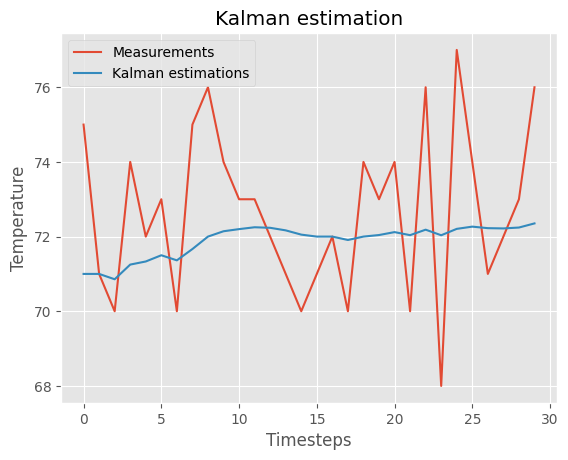

In [4]:

fig,ax=plt.subplots()

plt.plot(measurements,label="Measurements")
plt.plot(ests,label="Kalman estimations")
# Add labels and title
plt.xlabel('Timesteps')
plt.ylabel('Temperature')
plt.title("Kalman estimation")
ax.legend()

plt.show()

2-D Kalman filter functions

In [26]:
delta_t = 1
x_0 = 4000
x_dot_0 = 280
a = 2 
A = jnp.array([[1,delta_t],
               [0,1]])
B = jnp.array([[0.5*delta_t**2],
               [delta_t]])
C=jnp.eye(2)
x_k = jnp.array([[x_0],
                 [x_dot_0]])
u_k = jnp.array([[a]])
w_k = jnp.zeros((2,1))
Q=jnp.zeros((2,1))
P=jnp.array([[400,0],
             [0,25]])
R=jnp.array([[625,0],
             [0,36]])
H=jnp.eye(2)
Z=jnp.zeros((2,1))
measurements=jnp.array([[4260,282],
                        [4550,285],
                        [4860,286],
                        [5110,290]])

In [14]:
K=kalman_function(P,H,R)
K

Array([[0.39889634, 0.24635395],
       [0.01418999, 0.40402046]], dtype=float32)

In [15]:
x_km=jnp.array([[4260],[282]])
x_kp=step_estimation(A,B,x_k,u_k,w_k)
x_k,P=current_state_and_process(K,H,C,x_km,x_kp,P,Z)

In [32]:
lo=np.array([95, 100, 50])
hi=np.array([105, 255, 255])

def detect_inrange(image, surface):
    points=[]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image=cv2.blur(image, (5, 5))
    mask=cv2.inRange(image, lo, hi)
    mask=cv2.erode(mask, None, iterations=2)
    mask=cv2.dilate(mask, None, iterations=2)
    elements=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    elements=sorted(elements, key=lambda x:cv2.contourArea(x), reverse=True)
    for element in elements:
        if cv2.contourArea(element)>surface:
            ((x, y), rayon)=cv2.minEnclosingCircle(element)
            points.append(np.array([int(x), int(y)]))
        else:
            break

    return points, mask

def detect_visage(image):
    face_cascade=cv2.CascadeClassifier("./haarcascade_frontalface_alt2.xml")
    points=[]
    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face=face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3)
    for x, y, w, h in face:
        points.append(np.array([int(x+w/2), int(y+h/2)]))

    return points, None

In [33]:
delta_t = .1
a = 0
A = jnp.array([[1,0,delta_t,0],
               [0,1,0,delta_t],
               [0,0,1,0],
               [0,0,0,1]])
B = jnp.array([[0.5*delta_t**2],[delta_t],[0],[0]])
C=jnp.eye(2)
R=jnp.array([[1,0],[0,1]])
H=jnp.array([[1,0,0,0],
             [0,1,0,0]])
Q=jnp.eye(4)
P0=jnp.eye(4)
x_k_0=jnp.zeros((4,1))
u_k = jnp.array([[a]])
w_k = jnp.zeros((4,1))
Z=jnp.zeros((2,1))

In [34]:
VideoCap=cv2.VideoCapture(0)

etat=x_k_0
P=P0


while(True):
    ret, frame=VideoCap.read()
    frame=cv2.flip(frame, 1)

    points, mask=detect_inrange(frame, 800)
    #points, mask=detect_visage(frame)

    etat=step_estimation(A,B,etat,u_k,w_k)
    P=process_covariance(A,P,Q)

    cv2.circle(frame, (int(etat[0,0]), int(etat[1,0])), 2, (0, 255, 0), 5)
    cv2.arrowedLine(frame,
                    (int(etat[0,0]), int(etat[1,0])), (int(etat[0,0])+int(etat[2,0]), int(etat[1,0])+int(etat[3,0])),
                    color=(0, 255, 0),
                    thickness=3,
                    tipLength=0.2)
    if (len(points)>0):
        cv2.circle(frame, (points[0][0], points[0][1]), 10, (0, 0, 255), 2)
        K=kalman_function(P,H,R)
        etat,P=current_state_and_process(K,H,C,np.expand_dims(points[0], axis=-1),etat,P,Z)

    cv2.imshow('image', frame)

    if cv2.waitKey(1)&0xFF==ord('q'):
        VideoCap.release()
        cv2.destroyAllWindows()
        break

In [35]:
import jax.numpy as jnp
delta_t = .5
a = 0
A = jnp.array([[1,0,delta_t,0,0,0],
               [0,1,0,delta_t,0,0],
               [0,0,1,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,0,1,0],
               [0,0,0,0,0,1]])
B = jnp.array([[0.5*delta_t**2],[delta_t],[0],[0],[0],[0]])
C=jnp.eye(4)

H=jnp.array([[1,0,0,0,0,0],
             [0,1,0,0,0,0],
             [0,0,0,0,1,0],
             [0,0,0,0,0,1]])
v=1E-5
Q=jnp.array([[v,0,0,0,0,0],
             [0,v,0,0,0,0],
             [0,0,v,0,0,0],
             [0,0,0,v,0,0],
             [0,0,0,0,v,0],
             [0,0,0,0,0,v]])
R=jnp.array([[v,0,0,0],
             [0,v,0,0],
             [0,0,v,0],
             [0,0,0,v]])
P0=jnp.eye(A.shape[1])
x_k_0=jnp.zeros((6,1))
u_k = jnp.array([[a]])
w_k = jnp.zeros((6,1))
Z=jnp.zeros((4,1))

In [45]:
import cv2
import numpy as np
from numpy import genfromtxt
import math
import os
import glob

distance_mini=500
rectangle=0
trace=0
P=P0

dir_images="C:/Users/hamed/Desktop/img1/"
fichier_label="C:/Users/hamed/Desktop/gt/gt.txt"

if not os.path.exists(dir_images):
    print("Le repertoire n'existe pas ...", dir_images)
    quit()

if not os.path.exists(fichier_label):
    print("Le fichier de label n'existe pas ...", fichier_label)
    quit()

objets_points=[]
objets_id=[]
#objets_KF=[]
object_etat=[]
object_P=[]
objets_historique=[]

def distance(point, liste_points):
    distances=[]
    for p in liste_points:
        distances.append(np.sum(np.power(p-np.expand_dims(point, axis=-1), 2)))
    return distances

def trace_historique(tab_points, longueur, couleur=(0, 255, 255)):
    historique=np.array(tab_points)
    nbr_point=len(historique)
    longueur=min(nbr_point, longueur)
    for i in range(nbr_point-1, nbr_point-longueur, -1):
        cv2.line(frame,
                 (historique[i-1, 0], historique[i-1, 1]),
                 (historique[i, 0], historique[i, 1]),
                 couleur,
                 2)

data=genfromtxt(fichier_label, delimiter=',')
id_frame=0
id_objet=0

start=0
for image in glob.glob(dir_images+"*.jpg"):
    frame=cv2.imread(image)

    # Prediction de l'ensemble des objets + affichage
    for id_obj in range(len(objets_points)):
        etat=step_estimation(A,B,object_etat[id_obj],u_k,w_k)
        P=process_covariance(A,object_P[id_obj],Q)
        #etat=objets_KF[id_obj].predict()
        etat=np.array(etat, dtype=np.int32)
        objets_points[id_obj]=np.array([[int(etat[0,0])], [int(etat[1,0])], [int(etat[4,0])], [int(etat[5,0])]])
        objets_historique[id_obj].append([[int(etat[0,0])], [int(etat[1,0])]])
        cv2.circle(frame, (int(etat[0,0]), int(etat[1,0])), 5, (0, 0, 255), 2)
        if rectangle:
            cv2.rectangle(frame,
                          (int(etat[0,0]-etat[4,0]/2), int(etat[1,0]-etat[5,0]/2)),
                          (int(etat[0,0]+etat[4,0]/2), int(etat[1]+etat[5,0]/2)),
                          (0, 0, 255),
                          2)
        cv2.arrowedLine(frame,
                        (int(etat[0,0]), int(etat[1,0])),
                        (int(etat[0,0])+3*int(etat[2,0]), int(etat[1,0])+3*int(etat[3,0])),
                        color=(0, 0, 255),
                        thickness=2,
                        tipLength=0.2)
        cv2.putText(frame,
                    "ID{:d}".format(objets_id[id_obj]),
                    (int(etat[0,0]-etat[4,0]/2), int(etat[1,0]-etat[5,0]/2)),
                    cv2.FONT_HERSHEY_PLAIN,
                    1.5,
                    (255, 0, 0),
                    2)

        if trace:
            trace_historique(objets_historique[id_obj], 42)

        # Permet de suivre l'ID 0 avec une flèche
        if objets_id[id_obj]==0:
            cv2.arrowedLine(frame,
                            (int(etat[0,0]), int(etat[1,0]-etat[5,0]/2-80)),
                            (int(etat[0,0]), int(etat[1,0]-etat[5,0]/2-30)),
                            color=(0, 0, 255),
                            thickness=5,
                            tipLength=0.2)

    # Récupération des objets de la frame concernée
    mask=data[:, 0]==id_frame
    

    # Affichage des données (rectangle) du detecteur
    points=[]
    for d in data[mask, :]:
        #if np.random.randint(2):
        if rectangle:
            cv2.rectangle(frame, (int(d[2]), int(d[3])), (int(d[2]+d[4]), int(d[3]+d[5])), (0, 255, 0), 2)
        xm=int(d[2]+d[4]/2)
        ym=int(d[3]+d[5]/2)
        cv2.circle(frame, (xm, ym), 2, (0, 255, 0), 2)
        points.append([xm, ym, int(d[4]), int(d[5])])

    # calcul des distances
    nouveaux_objets=np.ones((len(points)))
    tab_distances=[]
    if len(objets_points):
        for point_id in range(len(points)):
            distances=distance(points[point_id], objets_points)
            tab_distances.append(distances)

        tab_distances=np.array(tab_distances)
        sorted_distances=np.sort(tab_distances, axis=None)

        for d in sorted_distances:
            if d>distance_mini:
                break
            id1, id2=np.where(tab_distances==d)
            if not len(id1) or not len(id2):
                continue
            tab_distances[id1, :]=distance_mini+1
            tab_distances[:, id2]=distance_mini+1
            K=kalman_function(P,H,R)
            etat,P=current_state_and_process(K,H,C,np.expand_dims(points[id1[0]], axis=-1),etat,P,Z)
            print(etat,P)
            object_etat[id2[0]]=etat
            object_P[id2[0]]=P

            #objets_KF[id2[0]].update(np.expand_dims(points[id1[0]], axis=-1))
            nouveaux_objets[id1]=0
            
    # Création du filtre de Kalman pour les nouveaux objets
    for point_id in range(len(points)):
        if nouveaux_objets[point_id]:
            print("NOUVEAU", points[point_id])
            
            objets_points.append(points[point_id])
            object_etat.append(jnp.array([[points[point_id][0]],
                                          [points[point_id][1]],
                                          [0],
                                          [0],
                                          [points[point_id][2]],
                                          [points[point_id][3]]]))
            object_P.append(P0)
            #objets_KF.append(KalmanFilter(0.5, [points[point_id][0], points[point_id][1]], [points[point_id][2], points[point_id][3]]))
            objets_id.append(id_objet)
            objets_historique.append([])
            id_objet+=1
        print(0)

    # Nettoyage ...
    tab_id=[]
    for id_point in range(len(objets_points)):
        if int(objets_points[id_point][0])<-100 or \
        int(objets_points[id_point][1])<-100 or \
        int(objets_points[id_point][0])>frame.shape[1]+100 or \
        int(objets_points[id_point][1])>frame.shape[0]+100:
            print("SUPPRESSION", objets_points[id_point])
            tab_id.append(id_point)

    for index in sorted(tab_id, reverse=True):
        del objets_points[index]
        #del objets_KF[index]
        del object_P[index]
        del object_etat[index]
        del objets_id[index]
        del objets_historique[index]

    cv2.rectangle(frame, (0, 0), (frame.shape[1], 30), (100, 100, 100), cv2.FILLED)
    message="Frame: {:03d}  Nbr personne: {:d}  nbr filtre: {:d}   [r]Rectangle: {:3}  [t]Trace: {:3}".format(id_frame,
                                                                                                            len(points),
                                                                                                            len(objets_points),
                                                                                                            "ON" if rectangle else "OFF",
                                                                                                            "ON" if trace else "OFF")
    cv2.putText(frame,
                message,
                (20, 20),
                cv2.FONT_HERSHEY_PLAIN,
                1,
                (255, 255, 255),
                1)

    cv2.imshow("frame", frame)
    key=cv2.waitKey(1)&0xFF
    if key==ord('r'):
        rectangle=not rectangle
    if key==ord('t'):
        trace=not trace
    if cv2.waitKey(1)&0xFF==ord('q'):

        cv2.destroyAllWindows()
        break
    id_frame+=1

NOUVEAU [514, 195, 31, 75]
0
NOUVEAU [274, 263, 32, 88]
0
NOUVEAU [654, 282, 42, 81]
0
[[512.0011  ]
 [195.0007  ]
 [-56.79909 ]
 [-34.799442]
 [ 31.00011 ]
 [ 75.00006 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[ 395.59467 ]
 [ 228.4733  ]
 [-103.3613  ]
 [ -21.410515]
 [  31.500397]
 [  81.50447 ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

NOUVEAU [493, 202, 31, 75]
0
NOUVEAU [322, 251, 31, 86]
0
NOUVEAU [581, 281, 39, 83]
0
[[489.00073 ]
 [203.00063 ]
 [-36.79941 ]
 [-31.199501]
 [ 31.00008 ]
 [ 75.00008 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[409.065   ]
 [226.48132 ]
 [-68.77345 ]
 [-21.807293]
 [ 31.00004 ]
 [ 80.5038  ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.000000

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[361.00128 ]
 [240.0003  ]
 [-63.19899 ]
 [-15.199757]
 [ 30.00005 ]
 [ 84.00001 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[406.9635  ]
 [225.51187 ]
 [-44.814255]
 [-20.995087]
 [ 30.500366]
 [ 79.496925]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[417.00034 ]
 [215.00046 ]
 [-17.199724]
 [-23.199629]
 [ 31.00001 ]
 [ 75.00009 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[560.88385   ]
 [271.4546    ]
 [ 40.353218  ]
 [ -0.61815643]
 [ 33.001373  ]
 [ 92.011665  ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9983684e-06 0.0000000e+00 8.000124

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[399.0002  ]
 [215.00037 ]
 [-10.799828]
 [-18.7997  ]
 [ 30.99999 ]
 [ 75.00008 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[412.4892   ]
 [237.48201  ]
 [ -5.4042754]
 [ -9.807115 ]
 [ 30.499653 ]
 [ 78.50243  ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9983684e-06 0.0000000e+00 8.0001241e-01 

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[ 395.00223 ]
 [ 216.00064 ]
 [-111.59821 ]
 [ -31.999489]
 [  30.99993 ]
 [  75.0002  ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[531.39087 ]
 [254.96881 ]
 [-57.043198]
 [-16.412342]
 [ 27.497572]
 [ 84.50659 ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9983684e-06 0.0000000e+00 8.0001241e-01 

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[593.9944  ]
 [285.998   ]
 [170.97424 ]
 [ 67.9908  ]
 [ 29.666718]
 [ 92.66687 ]] [[1.0002485e-05 0.0000000e+00 2.0003670e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.0002485e-05 0.0000000e+00 2.0003670e-05 0.0000000e+00
  0.0000000e+00]
 [1.9997358e-05 0.0000000e+00 9.9956989e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9997358e-05 0.0000000e+00 9.9956989e-05 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.5557243e-06
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.5557243e-06]]
[[519.988   ]
 [259.4957  ]
 [ 23.017792]
 [ 15.006397]
 [ 29.4286  ]
 [ 87.07145 ]] [[5.0006211e-06 0.0000000e+00 1.0000592e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 5.0006211e-06 0.0000000e+00 1.0000592e-05 0.0000000e+00
  0.0000000e+00]
 [9.9974368e-06 0.0000000e+00 7.9958445e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 9.9974368e-0

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

[[603.0011  ]
 [271.0005  ]
 [-53.999134]
 [-24.399609]
 [ 24.00009 ]
 [ 90.00026 ]] [[9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.983858e-06 0.000000e+00 3.993511e-06 0.000000e+00
  0.000000e+00]
 [3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.993511e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.001368e-05
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.001368e-05]]
[[667.4484  ]
 [299.9768  ]
 [-28.2204  ]
 [-12.809169]
 [ 29.003462]
 [103.00902 ]] [[4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 4.9959613e-06 0.0000000e+00 1.9983686e-06 0.0000000e+00
  0.0000000e+00]
 [1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 1.9983684e-06 0.0000000e+00 8.0001241e-01 0.0000

C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\63343067.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][0])>frame.shape

In [17]:
class KalmanFilter(object):
    def __init__(self, dt, point, box):
        self.dt=dt

        # Vecteur d'etat initial
        self.E=np.matrix([[point[0]], [point[1]], [0], [0], [box[0]], [box[1]]])

        # Matrice de transition
        self.A=np.matrix([[1, 0, self.dt, 0, 0, 0],
                          [0, 1, 0, self.dt, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

        # Matrice d'observation, on observe que x et y
        self.H=np.matrix([[1, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

        v=1E-5
        #v=1
        self.Q=np.matrix([[v, 0, 0, 0, 0, 0],
                          [0, v, 0, 0, 0, 0],
                          [0, 0, v, 0, 0, 0],
                          [0, 0, 0, v, 0, 0],
                          [0, 0, 0, 0, v, 0],
                          [0, 0, 0, 0, 0, v]])

        v=1E-5
        #v=1
        self.R=np.matrix([[v, 0, 0, 0],
                          [0, v, 0, 0],
                          [0, 0, v, 0],
                          [0, 0, 0, v]])

        self.P=np.eye(self.A.shape[1])

    def predict(self):
        self.E=np.dot(self.A, self.E)
        # Calcul de la covariance de l'erreur
        self.P=np.dot(np.dot(self.A, self.P), self.A.T)+self.Q
        return self.E

    def update(self, z):
        # Calcul du gain de Kalman
        S=np.dot(self.H, np.dot(self.P, self.H.T))+self.R
        K=np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        # Correction / innovation
        self.E=np.round(self.E+np.dot(K, (z-np.dot(self.H, self.E))))
        I=np.eye(self.H.shape[1])
        self.P=(I-(K*self.H))*self.P

        return self.E

class KalmanFilter_old(object):
    def __init__(self, dt, point, box):
        self.dt=dt

        # Vecteur d'etat initial
        self.E=np.matrix([[point[0]], [point[1]], [0], [0], [box[0]], [box[1]], [0], [0]])

        # Matrice de transition
        self.A=np.matrix([[1, 0, self.dt, 0, 0, 0, 0, 0],
                          [0, 1, 0, self.dt, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, self.dt, 0],
                          [0, 0, 0, 0, 0, 1, 0, self.dt],
                          [0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1]])

        # Matrice d'observation, on observe que x et y
        self.H=np.matrix([[1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0]])

        self.Q=np.matrix([[1, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1]])

        self.R=np.matrix([[1, 0, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])

        self.P=np.eye(self.A.shape[1])

    def predict(self):
        self.E=np.dot(self.A, self.E)
        # Calcul de la covariance de l'erreur
        self.P=np.dot(np.dot(self.A, self.P), self.A.T)+self.Q
        return self.E

    def update(self, z):
        # Calcul du gain de Kalman
        S=np.dot(self.H, np.dot(self.P, self.H.T))+self.R
        K=np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        # Correction / innovation
        self.E=np.round(self.E+np.dot(K, (z-np.dot(self.H, self.E))))
        I=np.eye(self.H.shape[1])
        self.P=(I-(K*self.H))*self.P

        return self.E

In [43]:
import cv2
import numpy as np
from numpy import genfromtxt
import math
import os
import glob



distance_mini=500
rectangle=0
trace=0

dir_images="C:/Users/hamed/Desktop/img1/"
fichier_label="C:/Users/hamed/Desktop/gt/gt.txt"

if not os.path.exists(dir_images):
    print("Le repertoire n'existe pas ...", dir_images)
    quit()

if not os.path.exists(fichier_label):
    print("Le fichier de label n'existe pas ...", fichier_label)
    quit()


objets_points=[]
objets_id=[]
objets_KF=[]
objets_historique=[]

def distance(point, liste_points):
    distances=[]
    for p in liste_points:
        distances.append(np.sum(np.power(p-np.expand_dims(point, axis=-1), 2)))
    return distances

def trace_historique(tab_points, longueur, couleur=(0, 255, 255)):
    historique=np.array(tab_points)
    nbr_point=len(historique)
    longueur=min(nbr_point, longueur)
    for i in range(nbr_point-1, nbr_point-longueur, -1):
        cv2.line(frame,
                 (historique[i-1, 0], historique[i-1, 1]),
                 (historique[i, 0], historique[i, 1]),
                 couleur,
                 2)

data=genfromtxt(fichier_label, delimiter=',')
id_frame=0
id_objet=0

start=0
for image in glob.glob(dir_images+"*.jpg"):
    frame=cv2.imread(image)

    # Prediction de l'ensemble des objets + affichage
    for id_obj in range(len(objets_points)):
        etat=objets_KF[id_obj].predict()
        etat=np.array(etat, dtype=np.int32)
        objets_points[id_obj]=np.array([etat[0], etat[1], etat[4], etat[5]])
        objets_historique[id_obj].append([etat[0], etat[1]])
        cv2.circle(frame, (int(etat[0,0]), int(etat[1,0])), 5, (0, 0, 255), 2)
        if rectangle:
            cv2.rectangle(frame,
                          (int(etat[0]-etat[4]/2), int(etat[1]-etat[5]/2)),
                          (int(etat[0]+etat[4]/2), int(etat[1]+etat[5]/2)),
                          (0, 0, 255),
                          2)
        cv2.arrowedLine(frame,
                (int(etat[0,0]), int(etat[1,0])),
                (int(etat[0,0])+3*int(etat[2,0]), int(etat[1,0])+3*int(etat[3,0])),
                color=(0, 0, 255),
                thickness=2,
                tipLength=0.2)
        cv2.putText(frame,
                    "ID{:d}".format(objets_id[id_obj]),
                    (int(etat[0]-etat[4]/2), int(etat[1]-etat[5]/2)),
                    cv2.FONT_HERSHEY_PLAIN,
                    1.5,
                    (255, 0, 0),
                    2)

        if trace:
            trace_historique(objets_historique[id_obj], 42)

        # Permet de suivre l'ID 0 avec une flèche
        if objets_id[id_obj]==0:
            cv2.arrowedLine(frame,
                            (int(etat[0,0]), int(etat[1,0]-etat[5,0]/2-80)),
                            (int(etat[0,0]), int(etat[1,0]-etat[5,0]/2-30)),
                            color=(0, 0, 255),
                            thickness=5,
                            tipLength=0.2)
    # Récupération des objets de la frame concernée
    mask=data[:, 0]==id_frame

    # Affichage des données (rectangle) du detecteur
    points=[]
    for d in data[mask, :]:
        #if np.random.randint(2):
        if rectangle:
            cv2.rectangle(frame, (int(d[2]), int(d[3])), (int(d[2]+d[4]), int(d[3]+d[5])), (0, 255, 0), 2)
        xm=int(d[2]+d[4]/2)
        ym=int(d[3]+d[5]/2)
        cv2.circle(frame, (xm, ym), 2, (0, 255, 0), 2)
        points.append([xm, ym, int(d[4]), int(d[5])])

    # calcul des distances
    nouveaux_objets=np.ones((len(points)))
    tab_distances=[]
    if len(objets_points):
        for point_id in range(len(points)):
            distances=distance(points[point_id], objets_points)
            tab_distances.append(distances)

        tab_distances=np.array(tab_distances)
        sorted_distances=np.sort(tab_distances, axis=None)

        for d in sorted_distances:
            
            if d>distance_mini:
                break
            id1, id2=np.where(tab_distances==d)
            if not len(id1) or not len(id2):
                continue
            tab_distances[id1, :]=distance_mini+1
            tab_distances[:, id2]=distance_mini+1
            objets_KF[id2[0]].update(np.expand_dims(points[id1[0]], axis=-1))
            print(objets_KF[id2[0]].E, objets_KF[id2[0]].P)
            nouveaux_objets[id1]=0

    # Création du filtre de Kalman pour les nouveaux objets
    for point_id in range(len(points)):
        if nouveaux_objets[point_id]:
            #print("NOUVEAU", points[point_id])
            objets_points.append(points[point_id])
            objets_KF.append(KalmanFilter(0.5, [points[point_id][0], points[point_id][1]], [points[point_id][2], points[point_id][3]]))
            objets_id.append(id_objet)
            objets_historique.append([])
            id_objet+=1

    # Nettoyage ...
    tab_id=[]
    for id_point in range(len(objets_points)):
        if int(objets_points[id_point][0])<-100 or \
        int(objets_points[id_point][1])<-100 or \
            objets_points[id_point][0]>frame.shape[1]+100 or \
            objets_points[id_point][1]>frame.shape[0]+100:
            #print("SUPPRESSION", objets_points[id_point])
            tab_id.append(id_point)

    for index in sorted(tab_id, reverse=True):
        del objets_points[index]
        del objets_KF[index]
        del objets_id[index]
        del objets_historique[index]

    cv2.rectangle(frame, (0, 0), (frame.shape[1], 30), (100, 100, 100), cv2.FILLED)
    message="Frame: {:03d}  Nbr personne: {:d}  nbr filtre: {:d}   [r]Rectangle: {:3}  [t]Trace: {:3}".format(id_frame,
                                                                                                            len(points),
                                                                                                            len(objets_points),
                                                                                                            "ON" if rectangle else "OFF",
                                                                                                            "ON" if trace else "OFF")
    cv2.putText(frame,
                message,
                (20, 20),
                cv2.FONT_HERSHEY_PLAIN,
                1,
                (255, 255, 255),
                1)
    cv2.imshow("frame", frame)
    key=cv2.waitKey(1)&0xFF
    if key==ord('r'):
        rectangle=not rectangle
    if key==ord('t'):
        trace=not trace
    if cv2.waitKey(1)&0xFF==ord('q'):

        cv2.destroyAllWindows()
        break
    id_frame+=1


C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\1514290135.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (int(etat[0]-etat[4]/2), int(etat[1]-etat[5]/2)),
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\1514290135.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(objets_points[id_point][0])<-100 or \
C:\Users\hamed\AppData\Local\Temp\ipykernel_13880\1514290135.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(objets_points[id_point][1]

[[512.]
 [195.]
 [ -1.]
 [  0.]
 [ 31.]
 [ 75.]] [[9.999920e-06 0.000000e+00 3.999936e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.999920e-06 0.000000e+00 3.999936e-06 0.000000e+00
  0.000000e+00]
 [3.999936e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.999936e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.999900e-06
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  9.999900e-06]]
[[279.]
 [262.]
 [  2.]
 [ -0.]
 [ 32.]
 [ 88.]] [[9.999920e-06 0.000000e+00 3.999936e-06 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 9.999920e-06 0.000000e+00 3.999936e-06 0.000000e+00
  0.000000e+00]
 [3.999936e-06 0.000000e+00 8.000132e-01 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 3.999936e-06 0.000000e+00 8.000132e-01 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.999900e-06
  0.

In [4]:
np.matrix([[1, 0, 0, 0, 0, 0]])

matrix([[1, 0, 0, 0, 0, 0]])

In [5]:
jnp.array([[1, 0, 0, 0, 0, 0]])

Array([[1, 0, 0, 0, 0, 0]], dtype=int32)